# Wavelet Transform #

1. Load images 

2. Convert to gray scale 

2. Wavelet transform 

In [1]:
import numpy as np
import cv2
import pywt
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display
import pywt
from skimage import color
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi
from collections import defaultdict
from scipy.stats import ks_2samp

Have to look into different wavelet transforms and choose the best one 

In [2]:
# Load frames into a 3D array
def load_frames(frame_paths):
    frames = [cv2.imread(frame) for frame in frame_paths]
    return np.stack(frames, axis=0)

# Apply 3D wavelet transform
def apply_3d_wavelet(frames, wavelet='db2'):
    coeffs = pywt.dwtn(frames, wavelet)
    return coeffs

def select_frames(directory, step=5):
    # Construct the path pattern to match all frames in the directory
    path_pattern = os.path.join(directory, '*.jpg')  # Adjust the extension if needed

    # Get a sorted list of all frame paths
    all_frames = sorted(glob.glob(path_pattern))

    # Select every 'step'th frame, including the first and last frames
    selected_frames = [all_frames[0]] + all_frames[1:-1:step] + [all_frames[-1]]

    return selected_frames

def convert_to_grayscale_and_mask(frames):
    # Initialize an empty list to hold the processed frames
    processed_frames = []
    
    for frame in frames:
        # Convert each frame to grayscale
        grayscale = color.rgb2gray(frame)
        
        # Apply Otsu's thresholding method to binarize the image
        thresh = threshold_otsu(grayscale)
        binary_mask = grayscale > thresh

        # Perform morphological closing to remove internal features
        closed_mask = ndi.binary_closing(binary_mask, structure=np.ones((3,3)))

        # Fill in small holes within the binary mask
        filled_mask = ndi.binary_fill_holes(closed_mask)
        
        # Append the processed frame to the list
        processed_frames.append(filled_mask)
    
    # Convert the list of processed frames to a 3D numpy array
    return np.stack(processed_frames, axis=0)

In [3]:
# Directory containing the frames
frame_directory = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames/MY16/1.1_6_my16_74_Set0_Pos0_Ch5_14012018_150051'

# Get the selected frame paths
frame_paths = select_frames(frame_directory)

# Load the selected frames
frames = load_frames(frame_paths)

# Convert frames to grayscale and apply mask
grayscale_masked_frames = convert_to_grayscale_and_mask(frames)

# Apply 3D wavelet transform on the processed frames
wavelet_coeffs = apply_3d_wavelet(grayscale_masked_frames)

### Visualize the masked frame and the size of the frames ###

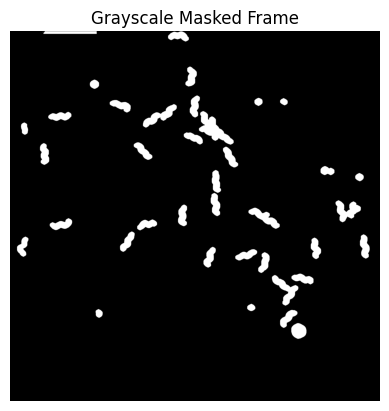

In [7]:
grayscale_masked_frames.shape
# Add this function to your existing code
def visualize_frame(frame):
    plt.imshow(frame, cmap='gray')
    plt.axis('off')  # Hide the axis
    plt.title('Grayscale Masked Frame')
    plt.show()

# Then call this function with a specific frame index, for example, to visualize the first frame:
visualize_frame(grayscale_masked_frames[0])


## Visualization ##

### Wavelet Coeffcient Heatmap ###

Allows to look at the distribution of intensities of coeffcient values

The number of coefficient sets extracted from a video using a 3D wavelet transform depends on the wavelet used and the level of decomposition. In a 3D discrete wavelet transform (DWT), each level of decomposition splits the data into different frequency bands. For a single level of decomposition with a basic wavelet (like 'Haar'), you get 8 sets of coefficients for a 3D dataset. These sets represent different combinations of low-pass (L) and high-pass (H) filtering along each of the three dimensions (two spatial dimensions and one temporal dimension).

The eight sets of coefficients for a single-level decomposition are:

1. LLL (Low on all three dimensions)

2. LLH (Low on the first two dimensions, High on the third)

3. LHL (Low on the first and third dimensions, High on the second)

4. LHH (Low on the first dimension, High on the second and third)

5. HLL (High on the first dimension, Low on the second and third)

6. HLH (High on the first and third dimensions, Low on the second)

7. HHL (High on the first two dimensions, Low on the third)

8. HHH (High on all three dimensions)

In [8]:
def plot_all_wavelet_heatmaps(coeffs):
    # Create a figure with 8 subplots (2 rows, 4 columns)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # List of coefficient keys
    coeff_keys = ['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']

    for i, key in enumerate(coeff_keys):
        # Extract the coefficients for the current key
        data = coeffs[key]

        # Select a 2D slice for visualization
        if data.ndim == 3:
            mid_frame = data.shape[0] // 2
            data_2d = data[mid_frame, :, :]
        else:
            data_2d = data  # If the data is already 2D

        # Plot heatmap in the corresponding subplot
        ax = axes[i // 4, i % 4]  # Determine the position of the subplot
        sns.heatmap(data_2d, cmap='viridis', ax=ax)
        ax.set_title(f"Heatmap of {key} coefficients")

    # Adjust layout
    plt.tight_layout()
    plt.show()

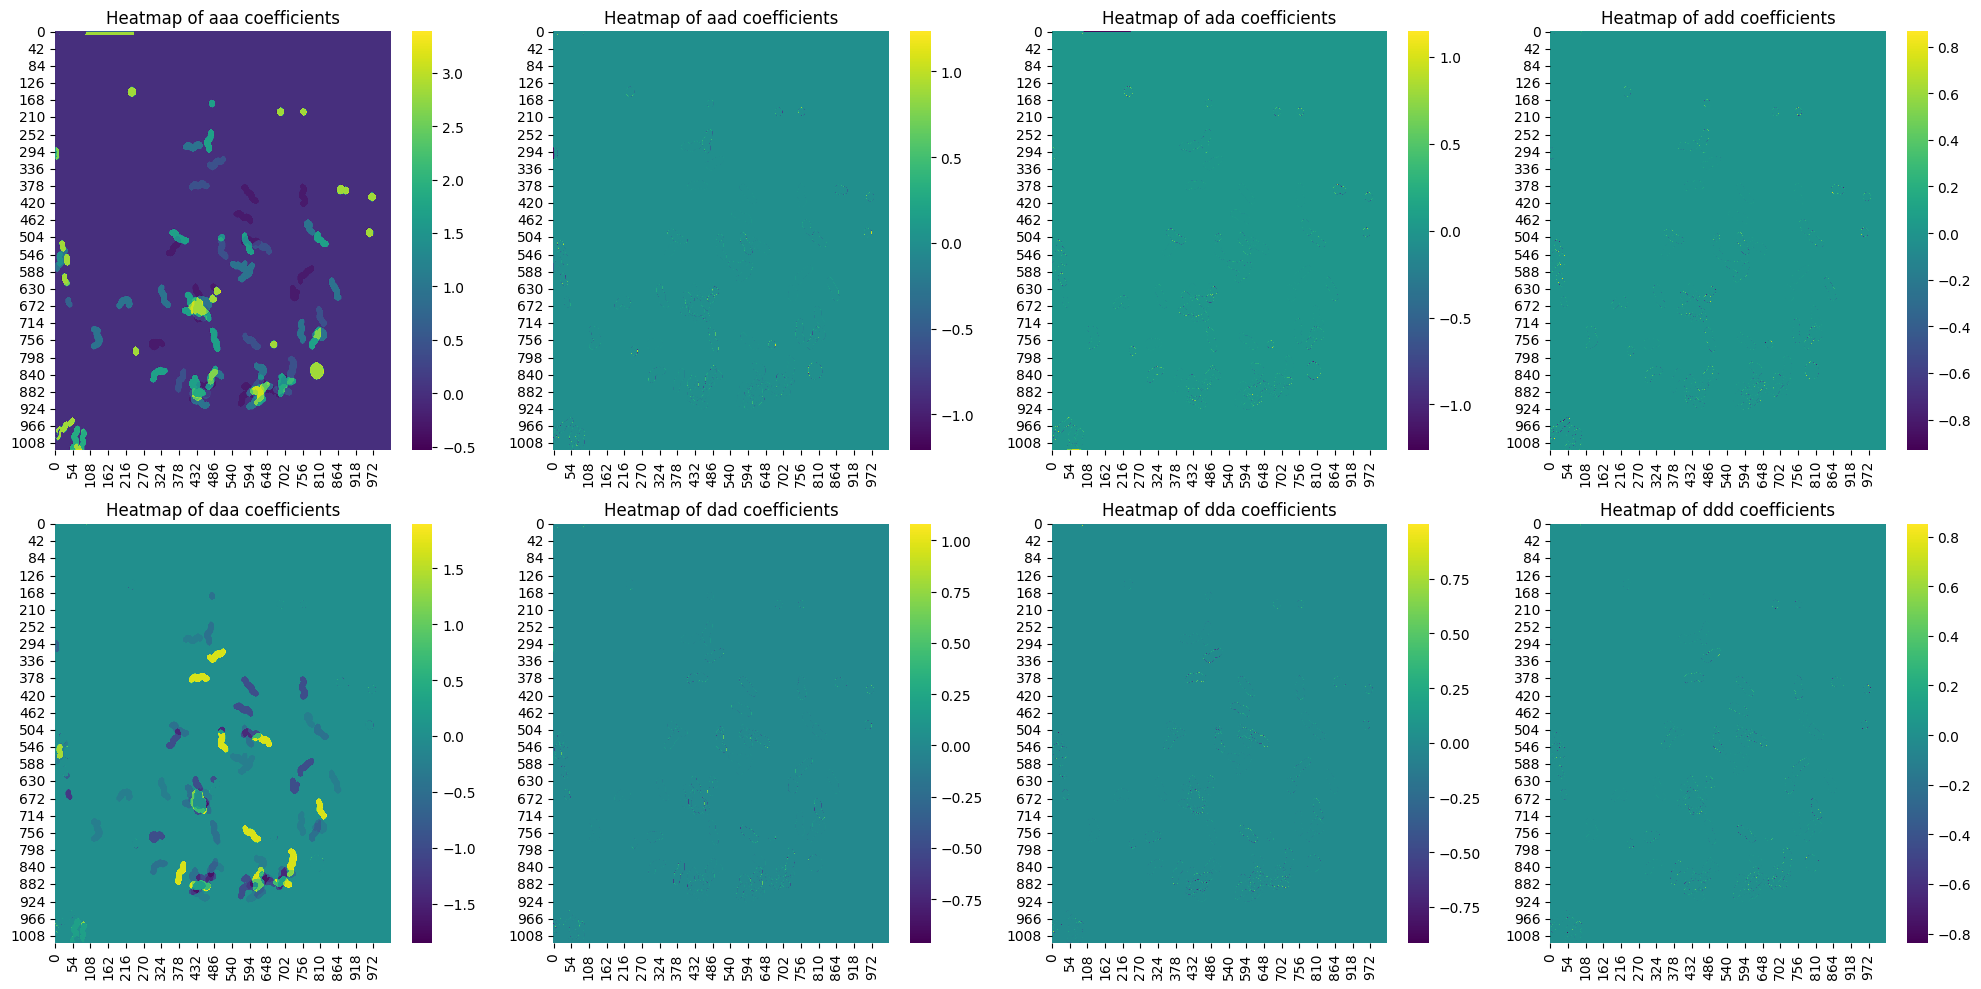

In [62]:
# print name of wavelet coefficients keys 
# print(wavelet_coeffs.keys())

# Assuming coeffs is your dictionary of wavelet coefficients
plot_all_wavelet_heatmaps(wavelet_coeffs)

In [63]:
# Iterate through each key in the wavelet_coeffs dictionary
for key, array in wavelet_coeffs.items():
    # Print the key and the shape of its corresponding array
    print(f"Shape of '{key}' coefficients: {array.shape}")

Shape of 'aaa' coefficients: (16, 1025, 1025)
Shape of 'aad' coefficients: (16, 1025, 1025)
Shape of 'ada' coefficients: (16, 1025, 1025)
Shape of 'add' coefficients: (16, 1025, 1025)
Shape of 'daa' coefficients: (16, 1025, 1025)
Shape of 'dad' coefficients: (16, 1025, 1025)
Shape of 'dda' coefficients: (16, 1025, 1025)
Shape of 'ddd' coefficients: (16, 1025, 1025)


### Temporal Evolution Plots ###

Not sure if this makes sense. Might come useful after. The spatial_location in plot_temporal_evolution allows you to selct a specifc part of the image spatialy [x,y]. This might come sueful after.  

In [8]:
def plot_temporal_evolution(coeffs, coeff_set, spatial_location):
    # Extract the specific set of coefficients
    coeff_data = coeffs[coeff_set]

    # Check if the data is 3D
    if coeff_data.ndim != 3:
        raise ValueError("Coefficient data is not 3D. Check the data structure.")

    # Time series for the specific spatial location
    time_series = coeff_data[:, spatial_location[0], spatial_location[1]]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(time_series)
    plt.title(f"Temporal Evolution of Coefficients at {spatial_location} in {coeff_set}")
    plt.xlabel('Frame Number')
    plt.ylabel('Coefficient Value')
    plt.show()

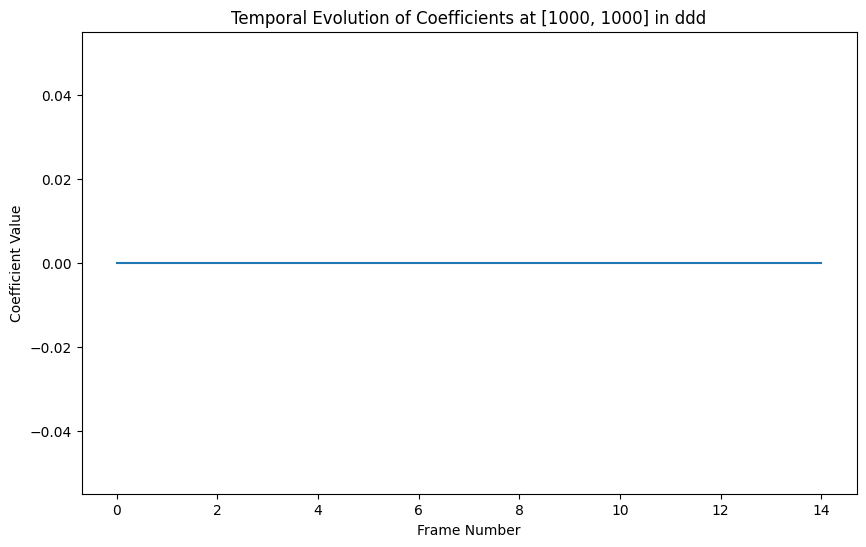

In [9]:
plot_temporal_evolution(wavelet_coeffs, 'ddd',[1000, 1000])

In [10]:
def plot_3d_surface(coeffs, coeff_set, frame_index):
    # Extract the coefficients for a specific frame
    frame_coeffs = coeffs[coeff_set][frame_index]

    # Create a meshgrid for the spatial dimensions
    X, Y = np.meshgrid(range(frame_coeffs.shape[1]), range(frame_coeffs.shape[0]))

    # 3D Surface Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, frame_coeffs, cmap='viridis', edgecolor='none')

    # Labels and Title
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Coefficient Intensity')
    ax.set_title(f"3D Surface Plot of '{coeff_set}' Coefficients - Frame {frame_index}")

    # Show the plot
    plt.show()

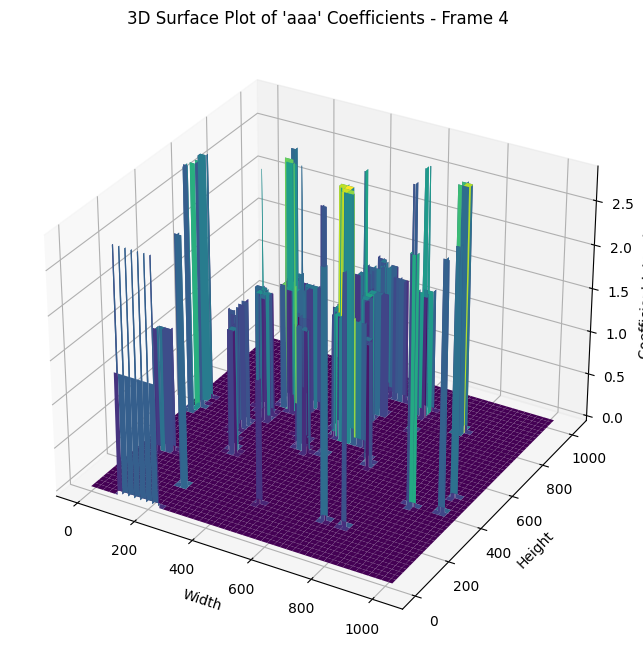

In [11]:
plot_3d_surface(wavelet_coeffs, 'aaa', 4)  # Visualize the first frame's 'aaa' coefficients

In [12]:
def interactive_3d_surface(coeffs, coeff_set):
    def plot(frame_index=0):
        frame_coeffs = coeffs[coeff_set][frame_index]
        X, Y = np.meshgrid(range(frame_coeffs.shape[1]), range(frame_coeffs.shape[0]))

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.clear()
        surf = ax.plot_surface(X, Y, frame_coeffs, cmap='viridis', edgecolor='none')
        ax.set_xlabel('Width')
        ax.set_ylabel('Height')
        ax.set_zlabel('Coefficient Intensity')
        ax.set_title(f"3D Surface Plot of '{coeff_set}' Coefficients - Frame {frame_index}")

    # Create a slider to select the frame number
    frame_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(coeffs[coeff_set]) - 1,
        step=1,
        description='Frame Number:',
        continuous_update=False
    )

    # Create an interactive widget
    widgets.interact(plot, frame_index=frame_slider)

In [13]:
# Example usage
interactive_3d_surface(wavelet_coeffs, 'aaa')

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame Number:', max=14), Output…

### Histogram coeffcients ###

 Histograms of Coefficients
Description: Use histograms to show the distribution of wavelet coefficients.
Implementation: matplotlib or seaborn can be used for histogram creation.
Advantages: Good for statistical analysis of the coefficients, understanding the spread and common values.

In [14]:
def plot_histograms_all_coeffs(coeffs_dict):
    # Determine the grid size
    num_coeffs = len(coeffs_dict)
    cols = 2  # for example, you can choose a different number
    rows = num_coeffs // cols + num_coeffs % cols

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.ravel()  # Flatten the axes array for easy indexing

    for i, (coeff_name, coeff_array) in enumerate(coeffs_dict.items()):
        # Flatten the coefficients to create a 1D array
        coeffs_flattened = coeff_array.flatten()

        # Plot the histogram on the ith subplot
        axes[i].hist(coeffs_flattened, bins=50, color='blue', edgecolor='black')
        axes[i].set_title(f'Histogram of {coeff_name} Coefficients')
        axes[i].set_xlabel('Coefficient Value')
        axes[i].set_ylabel('Frequency')

    # Hide any unused subplots
    for j in range(i+1, rows * cols):
        axes[j].axis('off')

    # Adjust layout for readability
    plt.tight_layout()
    plt.show()


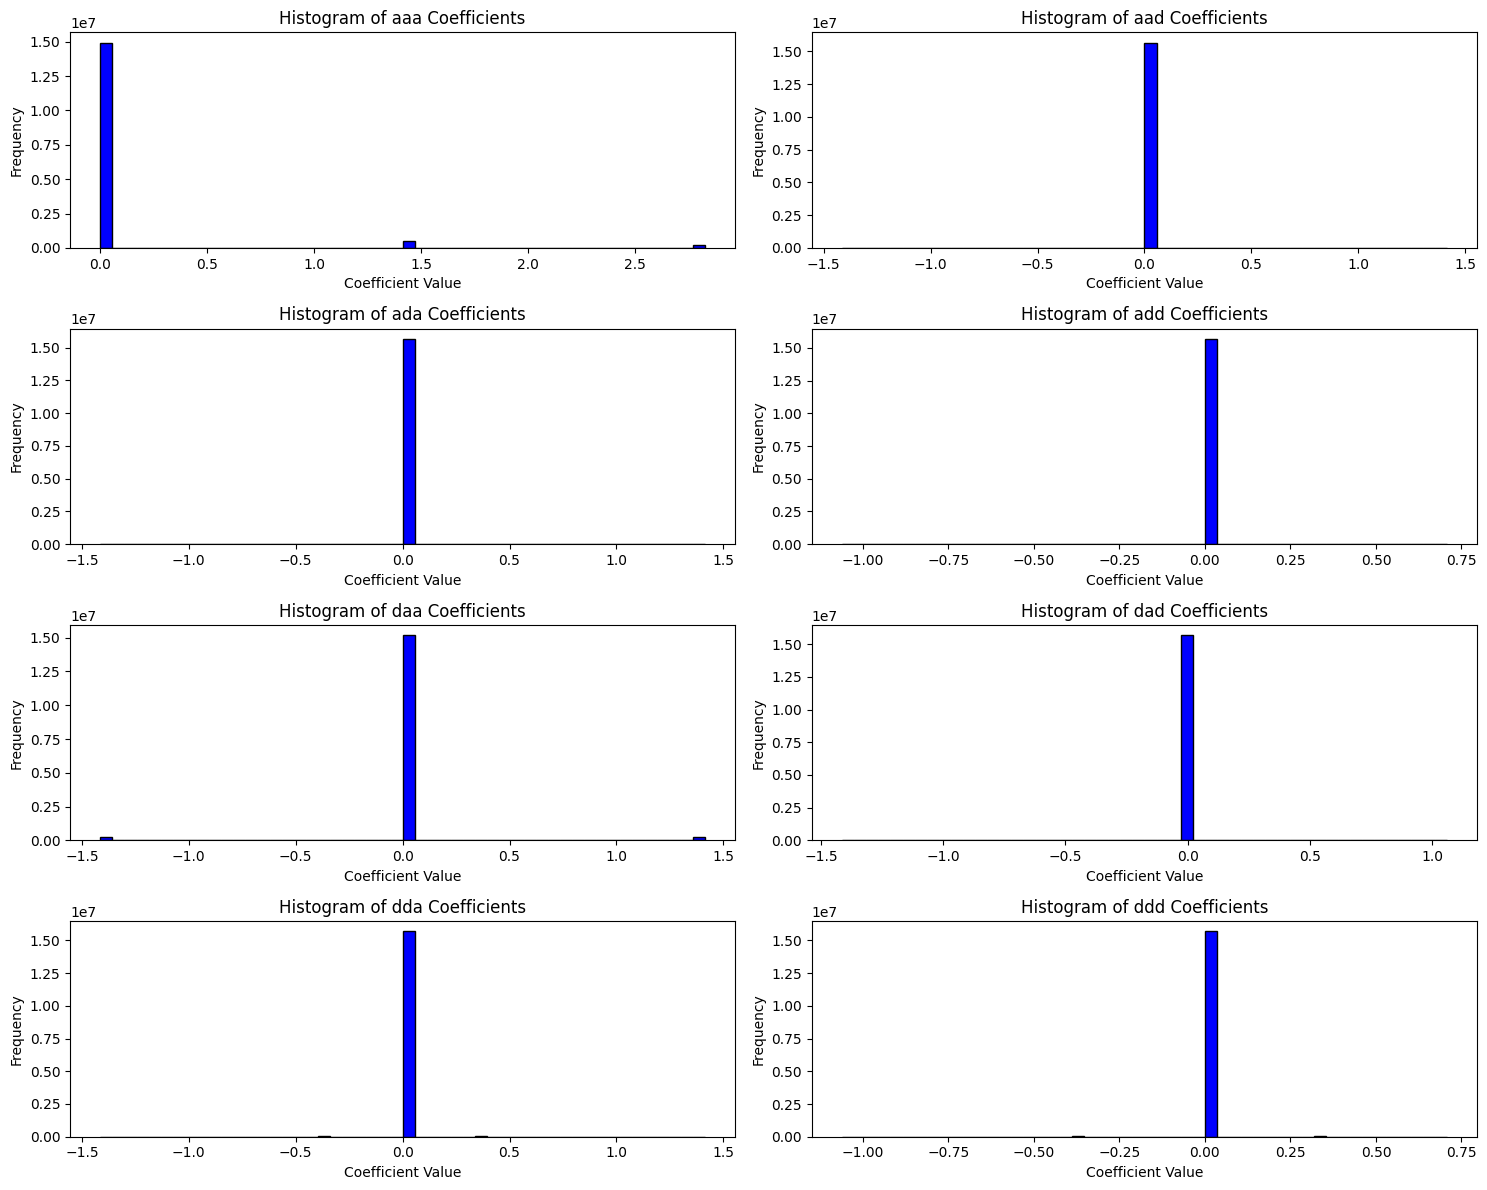

In [15]:
plot_histograms_all_coeffs(wavelet_coeffs)

### Animation of Wavelet Transformed Frames ###

Description: Create an animation showing the transformation of frames over time.
Implementation: Use matplotlib.animation or OpenCV for creating animations.
Advantages: Offers a dynamic and intuitive understanding of changes throughout the video.

In [16]:
from matplotlib.animation import FuncAnimation


def animate_wavelet_transformed_frames(coeffs, coeff_set):
    # Extract the set of coefficients
    frames = coeffs[coeff_set]

    # Set up the figure
    fig, ax = plt.subplots()
    ax.set_title(f"Animation of '{coeff_set}' Coefficients Over Time")

    # Initialize a frame for the animation
    frame = ax.imshow(frames[0], cmap='gray', interpolation='none')
    ax.axis('off')

    # Update function for the animation
    def update(i):
        frame.set_data(frames[i])
        return frame,

    # Create the animation
    anim = FuncAnimation(fig, update, frames=len(frames), interval=50, blit=True)

    return anim

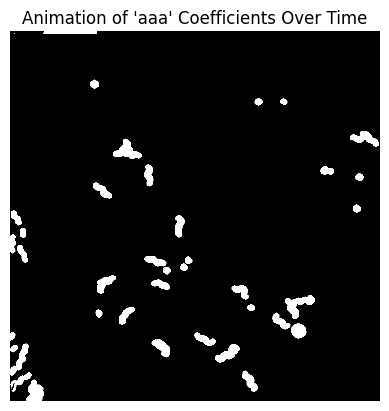

In [17]:
# Assuming 'wavelet_coeffs' is your dictionary of wavelet coefficients
anim = animate_wavelet_transformed_frames(wavelet_coeffs, 'aaa')

from IPython.display import HTML
HTML(anim.to_html5_video())


### Interactive Visualization with Jupyter Widgets ###

Description: Create interactive widgets in Jupyter Notebook for real-time manipulation and visualization of wavelet coefficients.
Implementation: Utilize ipywidgets for slider controls, dropdown menus, etc., to interactively explore different decomposition levels or frames.
Advantages: Provides an interactive environment for exploration and analysis.

In [18]:
def interactive_wavelet_visualization(coeffs_dict):
    # Create a dropdown to select the coefficient set
    coeff_set_dropdown = widgets.Dropdown(
        options=list(coeffs_dict.keys()),
        value=list(coeffs_dict.keys())[0],
        description='Coeff Set:',
    )

    # Create a slider for selecting the frame index
    frame_slider = widgets.IntSlider(
        min=0,
        max=coeffs_dict[list(coeffs_dict.keys())[0]].shape[0] - 1,
        step=1,
        value=0,
        description='Frame:',
    )

    # Function to update the plot
    def update_plot(coeff_set, frame_index):
        plt.figure(figsize=(6, 6))
        plt.imshow(coeffs_dict[coeff_set][frame_index], cmap='gray')
        plt.title(f"{coeff_set} Coefficients - Frame {frame_index}")
        plt.axis('off')
        plt.show()

    # Create interactive widgets
    widgets.interactive(update_plot, coeff_set=coeff_set_dropdown, frame_index=frame_slider)

In [19]:
# Assuming 'wavelet_coeffs' is your dictionary of wavelet coefficients
interactive_wavelet_visualization(wavelet_coeffs)

## Statistical Analysis non zero coefficients ##

In [8]:
# Assuming 'wavelet_coeffs' is a dictionary with keys like 'aaa' corresponding to the coefficients
# and each key is associated with a 3D numpy array where the first dimension is the frame index

# Function to calculate statistics on non-zero coefficients for a numpy array
def calculate_statistics(coeffs_array):
    # Flatten the array and filter out zeros
    non_zero_coeffs = coeffs_array[coeffs_array != 0]

    # Calculate the desired statistics
    stats = {
        'mean': np.mean(non_zero_coeffs) if non_zero_coeffs.size else 0,
        'std': np.std(non_zero_coeffs) if non_zero_coeffs.size else 0,
        'median': np.median(non_zero_coeffs) if non_zero_coeffs.size else 0,
        'min': np.min(non_zero_coeffs) if non_zero_coeffs.size else np.nan,
        'max': np.max(non_zero_coeffs) if non_zero_coeffs.size else np.nan,
        # Add more statistics as needed
    }
    return stats

In [9]:
# Apply the function to each frame (for each key if necessary) and store the results in a list
frame_statistics = {key: [calculate_statistics(coeffs[i, :, :]) for i in range(coeffs.shape[0])]
                    for key, coeffs in wavelet_coeffs.items()}

# Assuming 'frame_statistics' is your list of dictionaries containing statistics for each frame
means = [stat['mean'] for stat in frame_statistics['aaa']]
stds = [stat['std'] for stat in frame_statistics['aaa']]
medians = [stat['median'] for stat in frame_statistics['aaa']]
frames = range(len(means))

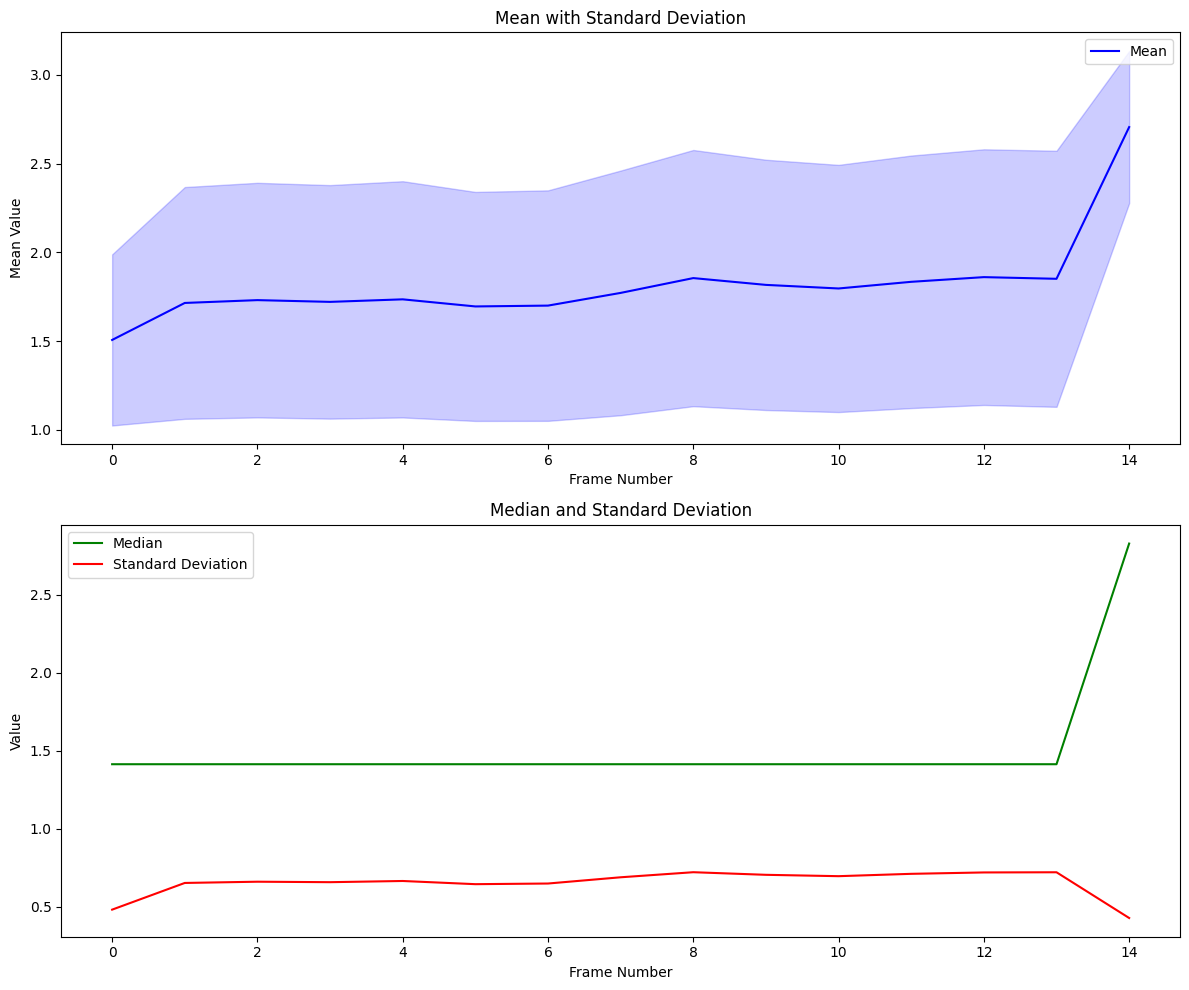

In [22]:
# Creating two subplots: one for mean with standard deviation, and another for median and standard deviation
plt.figure(figsize=(12, 10))

# Subplot 1: Mean with Standard Deviation
plt.subplot(2, 1, 1)
plt.fill_between(frames, [m - s for m, s in zip(means, stds)], 
                 [m + s for m, s in zip(means, stds)], color='blue', alpha=0.2)
plt.plot(frames, means, label='Mean', color='blue')
plt.title('Mean with Standard Deviation')
plt.xlabel('Frame Number')
plt.ylabel('Mean Value')
plt.legend()

# Subplot 2: Median and Standard Deviation
plt.subplot(2, 1, 2)
plt.plot(frames, medians, label='Median', color='green')
plt.plot(frames, stds, label='Standard Deviation', color='red')
plt.title('Median and Standard Deviation')
plt.xlabel('Frame Number')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


### Visualizing entire video in violin plot ###

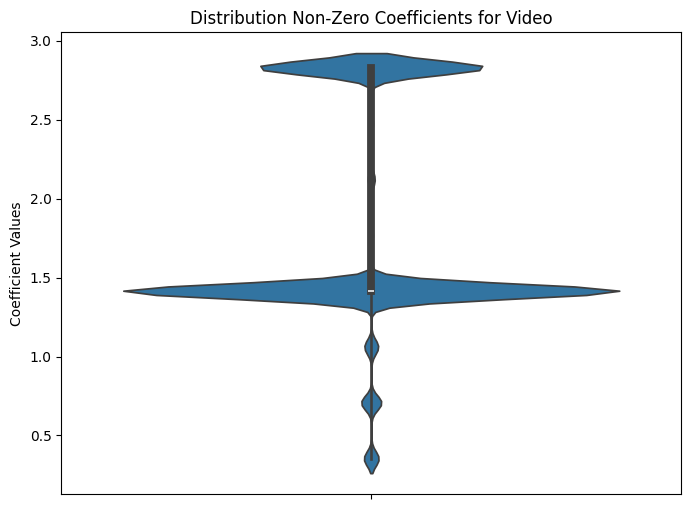

In [10]:
# Assuming 'wavelet_coeffs' is your dictionary of coefficients
# Extracting all non-zero coefficients from a specific key, e.g., 'aaa'
non_zero_coeffs = wavelet_coeffs['aaa'][wavelet_coeffs['aaa'] != 0]

# Creating the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(y=non_zero_coeffs)
plt.title('Distribution Non-Zero Coefficients for Video')
plt.ylabel('Coefficient Values')

plt.show()


# Applying to all experiments and all species #

In [8]:
from collections import defaultdict

# Load frames into a 3D array
def load_frames(frame_paths):
    frames = [cv2.imread(frame) for frame in frame_paths]
    return np.stack(frames, axis=0)

# Apply 3D wavelet transform
def apply_3d_wavelet(frames, wavelet='db2'):
    coeffs = pywt.dwtn(frames, wavelet)
    return coeffs

def select_frames(directory, step=5):
    path_pattern = os.path.join(directory, '*.jpg')
    all_frames = sorted(glob.glob(path_pattern))
    selected_frames = [all_frames[0]] + all_frames[1:-1:step] + [all_frames[-1]]
    return selected_frames

def convert_to_grayscale_and_mask(frames):
    processed_frames = []
    for frame in frames:
        grayscale = color.rgb2gray(frame)
        thresh = threshold_otsu(grayscale)
        binary_mask = grayscale > thresh
        closed_mask = ndi.binary_closing(binary_mask, structure=np.ones((3,3)))
        filled_mask = ndi.binary_fill_holes(closed_mask)
        processed_frames.append(filled_mask)
    return np.stack(processed_frames, axis=0)

def calculate_global_min_max(strain_coefficients):
    global_min_max = defaultdict(lambda: {'min': np.inf, 'max': -np.inf})
    for strain, coeffs_by_key in strain_coefficients.items():
        for key, coeffs in coeffs_by_key.items():
            if coeffs:  # Ensure there are coefficients to evaluate
                current_min = min(coeffs)
                current_max = max(coeffs)
                if current_min < global_min_max[key]['min']:
                    global_min_max[key]['min'] = current_min
                if current_max > global_min_max[key]['max']:
                    global_min_max[key]['max'] = current_max
    return global_min_max

def normalize_coefficients(strain_coefficients, global_min_max):
    normalized_coefficients = defaultdict(lambda: defaultdict(list))
    for strain, coeffs_by_key in strain_coefficients.items():
        for key, coeffs in coeffs_by_key.items():
            min_val = global_min_max[key]['min']
            max_val = global_min_max[key]['max']
            if max_val > min_val:  # Avoid division by zero
                # Normalize coefficients
                normalized = [(c - min_val) / (max_val - min_val) for c in coeffs]
                normalized_coefficients[strain][key].extend(normalized)
            else:
                normalized_coefficients[strain][key].extend(coeffs)
    return normalized_coefficients

def calculate_statistics(wavelet_coeffs):
    stats = {}
    all_coeffs_by_key = defaultdict(list)  # Use a dictionary to store coefficients by key

    for key, coeffs_array in wavelet_coeffs.items():
        non_zero_coeffs = coeffs_array[coeffs_array != 0]
        all_coeffs_by_key[key].extend(non_zero_coeffs)  # Store non-zero coefficients for each key

        component_stats = {
            'mean': np.mean(non_zero_coeffs) if non_zero_coeffs.size else 0,
            'std': np.std(non_zero_coeffs) if non_zero_coeffs.size else 0,
            'median': np.median(non_zero_coeffs) if non_zero_coeffs.size else 0,
            'min': np.min(non_zero_coeffs) if non_zero_coeffs.size else np.nan,
            'max': np.max(non_zero_coeffs) if non_zero_coeffs.size else np.nan,
        }
        stats[key] = component_stats

    return stats, all_coeffs_by_key

def process_video(video_directory):
    frame_paths = select_frames(video_directory)
    frames = load_frames(frame_paths)
    grayscale_masked_frames = convert_to_grayscale_and_mask(frames)
    wavelet_coeffs = apply_3d_wavelet(grayscale_masked_frames)
    stats, non_zero_coeffs_by_key = calculate_statistics(wavelet_coeffs)
    return stats, non_zero_coeffs_by_key

# Path to the root directory containing all species' folders
root_directory = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames'

# Dictionary to hold statistics for each video
all_video_statistics = {}
strain_coefficients = defaultdict(lambda: defaultdict(list))

# Iterate over each species folder
for species_name in os.listdir(root_directory):
    species_path = os.path.join(root_directory, species_name)
    if os.path.isdir(species_path):
        for experiment_name in os.listdir(species_path):
            experiment_path = os.path.join(species_path, experiment_name)
            if os.path.isdir(experiment_path):
                # Process the video and get the statistics and non-zero coefficients by key
                video_stats, non_zero_coeffs_by_key = process_video(experiment_path)
                video_identifier = f"{species_name}_{experiment_name}"
                all_video_statistics[video_identifier] = video_stats

                # For each key in non_zero_coeffs_by_key, extend the corresponding list in strain_coefficients
                for key, coeffs in non_zero_coeffs_by_key.items():
                    strain_coefficients[species_name][key].extend(coeffs)

In [4]:
strain_names = list(strain_coefficients.keys())

# Print the list of strain names
print(strain_names)

['N2', 'MY23', 'CB4856', 'MY16', 'da609', 'CX11314', 'DL238', 'ED3017', 'EG4725', 'JT11398', 'JU258', 'JU775', 'LKC34']


In [9]:
global_min_max = calculate_global_min_max(strain_coefficients)

# Normalize coefficients across all strains
normalized_coefficients = normalize_coefficients(strain_coefficients, global_min_max)


# Assuming strain_coefficients is your updated nested dictionary
# Example: strain_coefficients = {'Strain1': {'aaa': [...], 'aab': [...], ...}, 'Strain2': {...}, ...}
# Specify the key you are interested in
key_of_interest = 'aaa'  # Replace with your specific key

# Create a figure for the combined violin plots
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed

# Concatenate all coefficients of the specific key into a single list and create a corresponding label list
all_coeffs = []
labels = []
for strain, coeffs_by_key in strain_coefficients.items():
    if key_of_interest in coeffs_by_key:  # Check if the key exists for the strain
        coeffs = coeffs_by_key[key_of_interest]
        all_coeffs.extend(coeffs)
        labels.extend([strain] * len(coeffs))

# Plot the combined violin plot for the specific key
sns.violinplot(x=labels, y=all_coeffs, inner="box", palette="Set3")

# The sns.stripplot line has been removed, so individual points will not be plotted.

plt.title(f'Violin Plots of Non-Zero Coefficients for Key \'{key_of_interest}\' Across Strains')
plt.ylabel(f'Coefficient Values of {key_of_interest}')
plt.xlabel('Strain')

plt.tight_layout()
plt.show()

# Concatenate all normalized coefficients of the specific key into a single list and create a corresponding label list
all_normalized_coeffs = []
labels = []
for strain, coeffs_by_key in normalized_coefficients.items():
    if key_of_interest in coeffs_by_key:  # Check if the key exists for the strain
        normalized_coeffs = coeffs_by_key[key_of_interest]
        all_normalized_coeffs.extend(normalized_coeffs)
        labels.extend([strain] * len(normalized_coeffs))

# Plot the combined violin plot for the specific key
sns.violinplot(x=labels, y=all_normalized_coeffs, inner="box", palette="Set3")
plt.title(f'Violin Plots of Normalized Non-Zero Coefficients for Key \'{key_of_interest}\' Across Strains')
plt.ylabel(f'Normalized Coefficient Values of {key_of_interest}')
plt.xlabel('Strain')
plt.tight_layout()
plt.show()


/var/folders/99/b0r6g2l169g1fgrf2xh2y3y40000gn/T/ipykernel_44136/3490041139.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=labels, y=all_coeffs, inner="box", palette="Set3")


### Small explenation on code ###

You initialize two empty lists, all_coeffs and labels.
You iterate over each strain in strain_coefficients.
For each strain, you check if the key_of_interest is present.
If it is, you retrieve the list of coefficients associated with that key.
You extend all_coeffs with these coefficients, meaning you add these coefficients to the end of the all_coeffs list.
You also extend labels with the strain name repeated as many times as there are coefficients. This associates each coefficient with its corresponding strain label.
When sns.violinplot is called with x=labels and y=all_coeffs, it groups the coefficients by the unique values in labels (which are the strain names). So, all coefficients that have the label 'Strain1' go into the first group, all coefficients with the label 'Strain2' go into the second group, and so on.

This is how all_coeffs is divided among the different strains in the violin plot:

Each unique value in labels corresponds to a different violin in the plot.
The coefficients in all_coeffs are matched to the correct violin based on the order of labels. Since each coefficient from all_coeffs has a corresponding label in labels, the plotting library knows which strain each coefficient belongs to.
The sns.stripplot command then overlays individual data points on top of the violins, which represent the actual coefficient values. The color='k' parameter sets the color of these points to black, and alpha=0.5 makes them semi-transparent so they don't completely obscure the underlying violin plot.

### Quantify difference and similarity of violin plots ###

In [36]:

# Example usage with two distributions from your dataset
dist1 = strain_coefficients['N2']['daa']
dist2 = strain_coefficients['MY23']['daa']

# Perform Kolmogorov-Smirnov test
ks_stat, ks_p_value = ks_2samp(dist1, dist2)

print(f"KS Statistic: {ks_stat}, P-value: {ks_p_value}")


KS Statistic: 0.03340785374031685, P-value: 0.0


## Clustering with the wavelet coefficients ##

This is using all coeffcients extracted 

In [54]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

# Assume strain_coefficients is your data with wavelet coefficients
# strain_coefficients = {'Video1': {'coef1': [...], 'coef2': [...], ...},
#                        'Video2': {'coef1': [...], 'coef2': [...], ...}, ...}

# Flatten the coefficients for each video into a single feature vector
features = []
video_names = []
for video, coeffs in strain_coefficients.items():
    flat_coeffs = np.concatenate([np.array(coeffs[key]) for key in coeffs])
    features.append(flat_coeffs)
    video_names.append(video)

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-Means Clustering
num_clusters = 3  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features_scaled)

# Assign videos to clusters
clustered_videos = defaultdict(list)
for video, cluster in zip(video_names, kmeans.labels_):
    clustered_videos[cluster].append(video)

# Print the clustered videos
for cluster, videos in clustered_videos.items():
    print(f"Cluster {cluster}: {videos}")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (13,) + inhomogeneous part.

This is using only non zero coeffcients. 

Here we have to use statistical values obtained by the non zero coeffcients in order to obtain vectors of the same size for each video. 

In [56]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

# Assuming strain_coefficients contains your data structured as:
# {'Video1': {'aaa': [...], 'aab': [...], ...}, 'Video2': {...}, ...}

# Function to calculate statistics for non-zero coefficients
def calculate_stats(non_zero_coeffs):
    if len(non_zero_coeffs) == 0:
        return np.zeros(4)  # Return a zero vector if there are no coefficients
    mean = np.mean(non_zero_coeffs)
    std = np.std(non_zero_coeffs)
    min_val = np.min(non_zero_coeffs)
    max_val = np.max(non_zero_coeffs)
    return np.array([mean, std, min_val, max_val])

# Prepare feature vectors for each video
features = []
video_names = list(strain_coefficients.keys())
for video in video_names:
    coeffs = strain_coefficients[video]
    all_stats = []
    for key in coeffs:
        non_zero_coeffs = [c for c in coeffs[key] if c != 0]
        stats = calculate_stats(non_zero_coeffs)
        all_stats.append(stats)
    feature_vector = np.concatenate(all_stats)
    features.append(feature_vector)

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-Means Clustering
num_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features_scaled)

# Assign videos to clusters
clustered_videos = defaultdict(list)
for video, cluster in zip(video_names, kmeans.labels_):
    clustered_videos[cluster].append(video)

# Print the clustered videos
for cluster, videos in clustered_videos.items():
    print(f"Cluster {cluster}: {videos}")

Cluster 1: ['N2']
Cluster 0: ['MY23', 'CB4856', 'da609', 'CX11314', 'DL238', 'ED3017', 'JT11398', 'JU775', 'LKC34']
Cluster 4: ['MY16']
Cluster 2: ['EG4725']
Cluster 3: ['JU258']


/Users/emmarusconi/miniconda3/envs/collectiveNematode/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


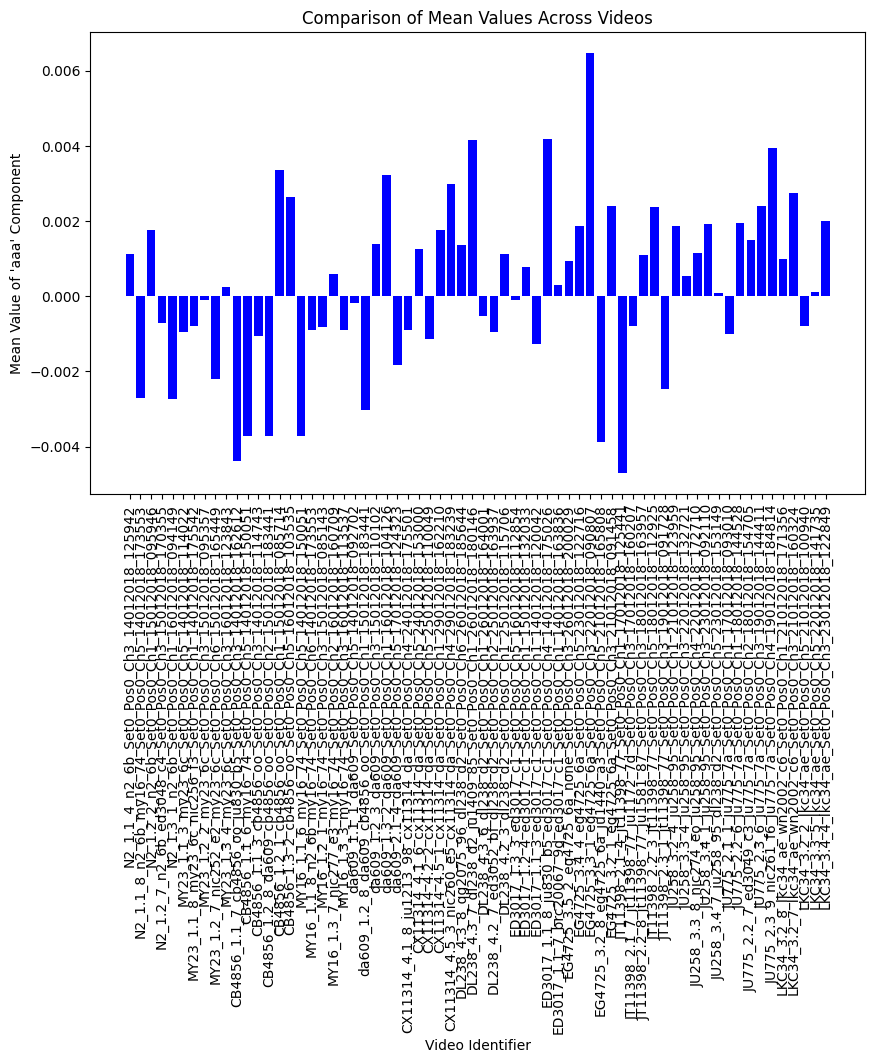

In [26]:
# Extracting 'mean' of 'aaa' component from each video
mean_values = [stats['ddd']['mean'] for stats in all_video_statistics.values()]
video_identifiers = list(all_video_statistics.keys())

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(video_identifiers, mean_values, color='blue')
plt.xlabel('Video Identifier')
plt.ylabel('Mean Value of \'aaa\' Component')
plt.title('Comparison of Mean Values Across Videos')
plt.xticks(rotation=90)  # Rotate labels for readability
plt.show()
